In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting
dc = datacube.Datacube(app='Snow monitoring with Landsat')

In [34]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
# lat, lon, buffer_m, buffer_n = -41.85, 146.38, 50000, 35000 #mt ossa
# lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
lat, lon, buffer_m, buffer_n = -41.87, 146, 8000, 8000 #mt ossa


#lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2016-09-01', '2017-10-28')
resolution = (-25, 25)
landsat_goodquality_prop = 0.70

ndsi_threshold = 0.4
ndvi_threshold = 0.3
ndwi_threshold = 0.15

In [35]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

In [37]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               sensors=['ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


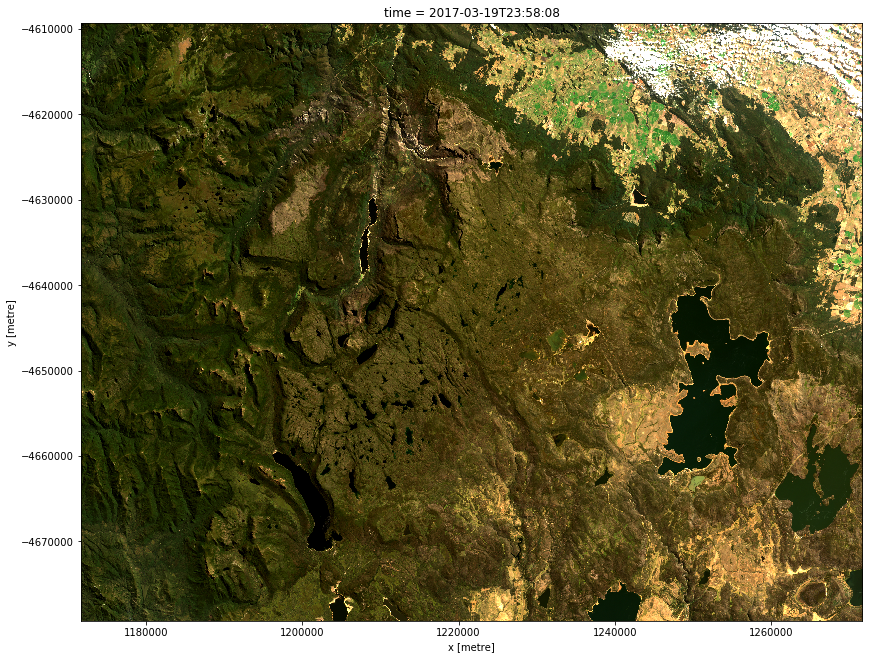

In [10]:
landsat_ds[['red', 'green', 'blue']].isel(time=3).to_array().plot.imshow(robust=True, figsize=(14, 11))

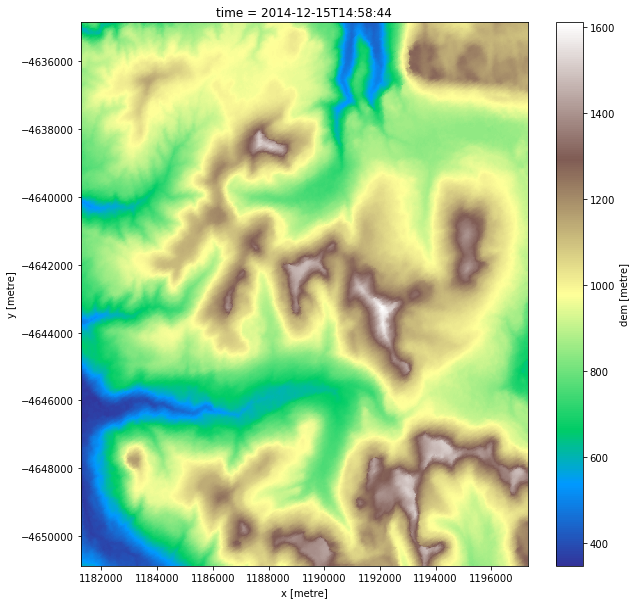

In [36]:
elevation_query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
elevation_data.dem.plot(figsize=(10,10),cmap='terrain')

In [12]:
elevation_2d = elevation_data.dem_h.squeeze('time')

In [13]:
#elev_list = [1800, 1500, 1200]
contour_gdf_1800 = SpatialTools.contour_extract(z_values=1800,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1800.shp')
contour_gdf_1500 = SpatialTools.contour_extract(z_values=1500,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1500.shp')
contour_gdf_1200 = SpatialTools.contour_extract(z_values=1200,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1200.shp')
contour_gdf_1000 = SpatialTools.contour_extract(z_values=1000,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1200.shp')
contour_gdf_800 = SpatialTools.contour_extract(z_values=800,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1200.shp')

contour_gdf = SpatialTools.contour_extract(z_values=[1200, 1000],
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_all.shp')



Operating in single array, multiple z-values mode
    Extracting contour 1800
    No data for contour 1800; skipping
Exporting contour shapefile to extracted_contours_1800.shp
Operating in single array, multiple z-values mode
    Extracting contour 1500
Exporting contour shapefile to extracted_contours_1500.shp
Operating in single array, multiple z-values mode
    Extracting contour 1200
Exporting contour shapefile to extracted_contours_1200.shp
Operating in single array, multiple z-values mode
    Extracting contour 1000
Exporting contour shapefile to extracted_contours_1200.shp
Operating in single array, multiple z-values mode
    Extracting contour 800
Exporting contour shapefile to extracted_contours_1200.shp
Operating in single array, multiple z-values mode
    Extracting contour 1200
    Extracting contour 1000
Exporting contour shapefile to extracted_contours_all.shp


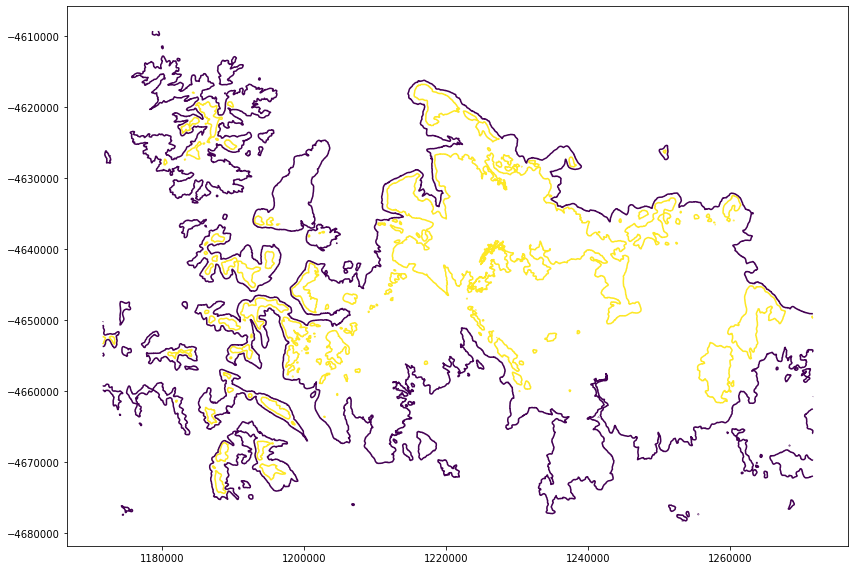

In [14]:
contour_gdf.plot(column='z_value',figsize=(14,11))

Text(0.5, 1, 'NSW alpine region [1800 m contour (blue)]')

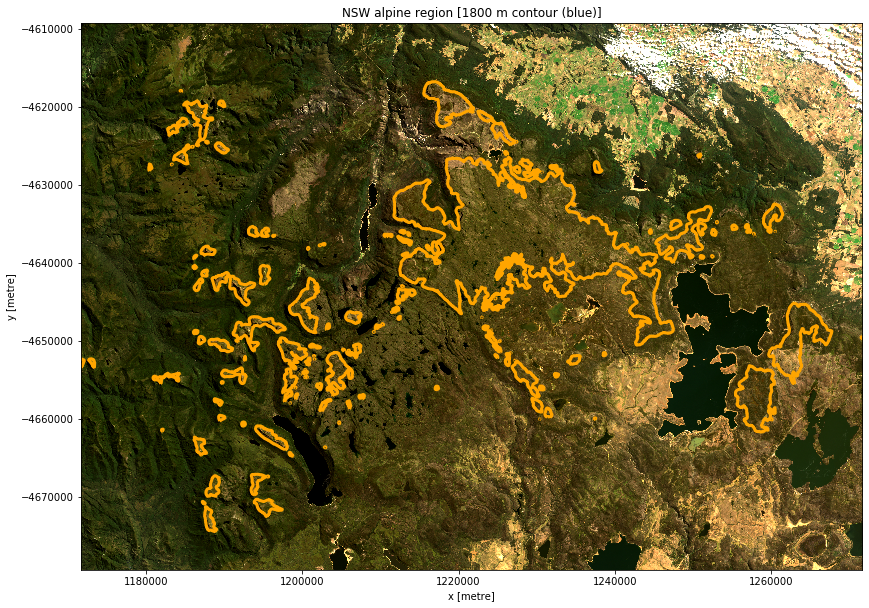

In [19]:
fig, ax = plt.subplots(figsize=(14,11))


landsat_ds[['red', 'green', 'blue']].isel(time=3).to_array().plot.imshow(robust=True)
# contour_gdf_800.plot(ax=ax, linewidth=3, color='mediumblue')
contour_gdf_1200.plot(ax=ax, linewidth=3, color='orange')
# contour_gdf_1200.plot(ax=ax, linewidth=3, color='firebrick')
plt.title('NSW alpine region [1800 m contour (blue)]')

Text(0.5, 1.0, 'NSW alpine region [1500 m contour (orange)]')

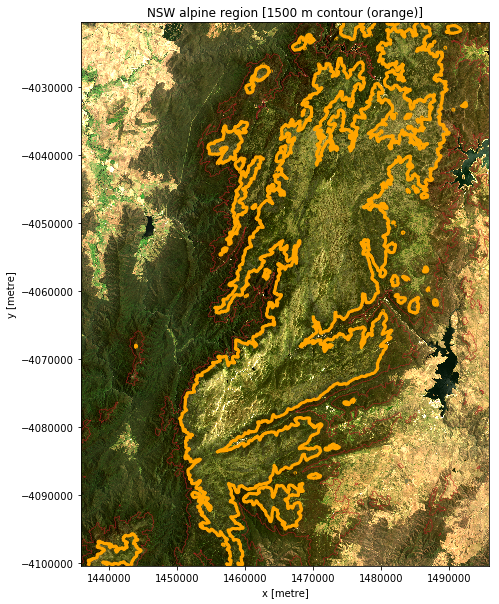

In [80]:
fig, ax = plt.subplots(figsize=(8,10))


landsat_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True)
#contour_gdf_1800.plot(ax=ax, linewidth=0.5, color='mediumblue')
contour_gdf_1500.plot(ax=ax, linewidth=3, color='orange')
contour_gdf_1200.plot(ax=ax, linewidth=0.5, color='firebrick')
plt.title('NSW alpine region [1500 m contour (orange)]')

Text(0.5, 1.0, 'NSW alpine region [1200 m contour (red)]')

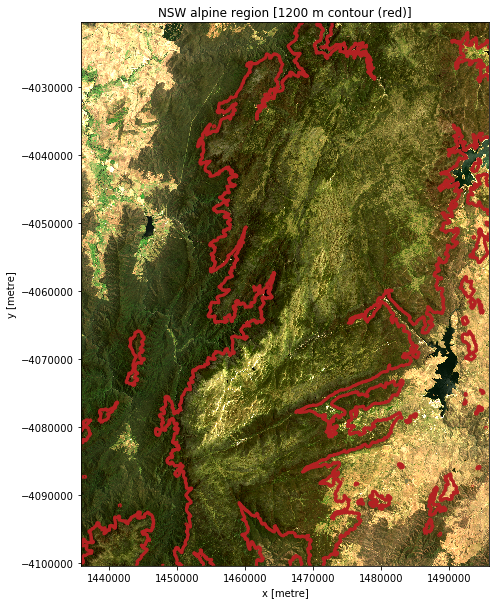

In [81]:
fig, ax = plt.subplots(figsize=(8,10))


landsat_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True)
#contour_gdf_1800.plot(ax=ax, linewidth=0.5, color='blue')
#contour_gdf_1500.plot(ax=ax, linewidth=0.5, color='aquamarine')
contour_gdf_1200.plot(ax=ax, linewidth=3, color='firebrick')
plt.title('NSW alpine region [1200 m contour (red)]')